Report Section 5.6: Dimensionality Reduction

In [1]:
# import relevant libraries

import requests 
import json 
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from kmodes.kprototypes import KPrototypes

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
from statsmodels.graphics.mosaicplot import mosaic
from pandas.plotting import parallel_coordinates
import prince


from sklearn.cluster import KMeans


from sklearn.metrics import silhouette_score


from sklearn.decomposition import PCA

In [2]:
#read the ‘dimensionality_reduction_subset’ csv

df = pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filecoin_messages_filrep_subset_expanded.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9249 entries, 0 to 9248
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                9249 non-null   object 
 1   account             9249 non-null   object 
 2   address             9249 non-null   object 
 3   type                9249 non-null   object 
 4   id                  9249 non-null   int64  
 5   name                4943 non-null   object 
 6   overEstimationBurn  9249 non-null   float64
 7   refundDecimal       9249 non-null   float64
 8   refund              9249 non-null   float64
 9   amountDecimal       9249 non-null   float64
 10  burnedDecimal       9249 non-null   float64
 11  signature           0 non-null      float64
 12  signedHash          0 non-null      float64
 13  success             9249 non-null   bool   
 14  minerPenalty        9249 non-null   float64
 15  minerTip            9249 non-null   float64
 16  exitCo

In [3]:
# encode the success column 
df['success'] = df['success'].astype(int)

In [4]:
#separate the continuous numerical values
numerical_features = ['refund', 'refundDecimal', 'amountDecimal', 'burnedDecimal', 'overEstimationBurn', 'baseFeeBurn', 'minerPenalty', 'minerTip','gas']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [6]:
# create another dataframe, which only has data needed in the model
num_df=df.drop(columns=['date','account','address','type','name','signature','signedHash'])


In [7]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [8]:
num_df.columns

Index(['id', 'overEstimationBurn', 'refundDecimal', 'refund', 'amountDecimal',
       'burnedDecimal', 'success', 'minerPenalty', 'minerTip', 'exitCode',
       'gas', 'baseFeeBurn'],
      dtype='object')

In [9]:
#separate categorical and numerical values
categorical_indices = [num_df.columns.get_loc(col) for col in ['id', 'success', 'exitCode']]
numerical_features= ['overEstimationBurn', 'refundDecimal', 'refund', 'amountDecimal',
       'burnedDecimal', 'minerPenalty', 'minerTip','gas', 'baseFeeBurn']



Technique 1: No PCA- Simple Clustering on the dataset - KPrototype

In [13]:
# code to plot the elbow and silhouette plots
def cluster(X):
    costs = []
    n_clusters = []
    clusters_assigned = []
    silhouette_scores = []

    for i in range(2, 10):
        try:
            kproto = KPrototypes(n_clusters=i, init='Huang', random_state=42,n_jobs=-2,max_iter=5,n_init=10,verbose=2) 
            clusters = kproto.fit_predict(X, categorical=categorical_indices)
            costs.append(kproto.cost_)
            n_clusters.append(i)
            clusters_assigned.append(clusters)
            silhouette_avg = silhouette_score(X, clusters)
            silhouette_scores.append(silhouette_avg)
        except:
            print(f"Can't cluster with {i} clusters")

    return costs, n_clusters, clusters_assigned, silhouette_scores

costs, n_clusters, clusters_assigned, silhouette_scores= cluster(num_df)


Best run was number 9
Best run was number 6
Best run was number 9
Best run was number 3
Best run was number 3
Best run was number 4
Best run was number 8
Best run was number 4


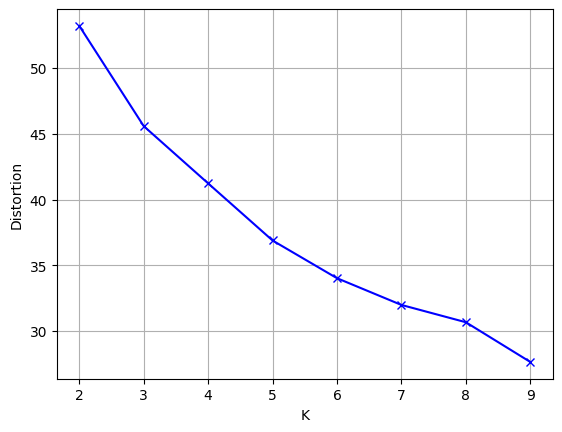

In [14]:

plt.plot(n_clusters, costs, 'bx-')
plt.ylabel('Distortion')
plt.xlabel('K');
plt.grid()

In [16]:
# 5 is the optimal number of clusters
kproto = KPrototypes(n_clusters=5, init='Cao', n_init=2, verbose=2, random_state=42)

# Fit the model
clusters = kproto.fit_predict(num_df.values, categorical=categorical_indices)

# Assign cluster labels to the DataFrame
num_df['cluster'] = clusters

# Create a mapping dictionary for cluster labels
cluster_mapping = {0: 0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1}

# Map cluster labels to specified values
num_df['cluster'] = num_df['cluster'].map(cluster_mapping)



Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1046, ncost: 46.51564461233752
Run: 1, iteration: 2/100, moves: 505, ncost: 46.13670520149518
Run: 1, iteration: 3/100, moves: 181, ncost: 45.509104735307375
Run: 1, iteration: 4/100, moves: 15, ncost: 45.50886747868753
Run: 1, iteration: 5/100, moves: 0, ncost: 45.50886747868753
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 674, ncost: 45.670605432976764
Run: 2, iteration: 2/100, moves: 172, ncost: 45.544201185091985
Run: 2, iteration: 3/100, moves: 42, ncost: 45.50922099805567
Run: 2, iteration: 4/100, moves: 5, ncost: 45.50886747868754
Run: 2, iteration: 5/100, moves: 0, ncost: 45.50886747868754
Best run was number 1


In [17]:
num_df.head()

,id,overEstimationBurn,refundDecimal,refund,amountDecimal,burnedDecimal,success,minerPenalty,minerTip,exitCode,gas,baseFeeBurn,cluster
0,0,6.436331e-05,1.301048e-03,1.301048e-03,0.331793,1.480909e-04,1,0.0,5.427090e-06,0,0.000869,1.414030e-04,1.00
1,0,6.881224e-12,2.643170e-11,2.643170e-11,0.117103,6.275459e-12,1,0.0,2.932049e-07,0,0.000037,5.202649e-12,1.00
2,7,9.994282e-03,2.897125e-02,2.897125e-02,0.111234,3.123789e-02,1,0.0,3.232164e-02,0,0.056080,3.050795e-02,1.00
3,6,2.399934e-03,1.988960e-02,1.988960e-02,0.007346,2.276021e-02,1,0.0,2.209272e-02,0,0.042012,2.315616e-02,0.75
4,5,2.829436e-04,1.125731e-02,1.125731e-02,0.000000,2.647547e-03,1,0.0,1.117123e-02,0,0.022369,2.692888e-03,0.00


In [18]:
# account is the identifier for all transactions
sender_df=df["account"]

In [19]:
# vertically concatenate the account with the clustered results
result_vertical = pd.concat([sender_df, num_df], axis=1)

In [20]:
# calculate average cluster for each account 
grouped_df = result_vertical.groupby('account').agg({
    'cluster': 'mean'})
print(grouped_df)

            cluster
account            
f01096727  0.013825
f01136409  0.077068
f0115238   0.010577
f0116445   0.092457
f0117318   0.003886
f01399784  0.263514
f01437863  0.011111
f01501611  0.022288
f015747    0.041436
f01690871  1.000000
f01812283  0.083333
f02072747  0.062950
f02184150  0.136364
f022853    0.260784
f023858    0.019585
f023869    0.023101
f02387     0.007407
f02388     0.044492
f023928    0.017978
f023983    0.006250
f024146    0.009732
f024148    0.015319
f024511    0.239362
f029416    0.126943
f030649    0.015432
f034777    0.069209
f0471691   0.143713
f054526    0.122407
f0728347   0.159091
f0835643   0.170723


In [21]:
sorted_df = grouped_df.sort_values(by='cluster', ascending=True)
print(sorted_df)
sorted_df.to_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filrepsubset_onlycluster_expanded.csv")

            cluster
account            
f0117318   0.003886
f023983    0.006250
f02387     0.007407
f024146    0.009732
f0115238   0.010577
f01437863  0.011111
f01096727  0.013825
f024148    0.015319
f030649    0.015432
f023928    0.017978
f023858    0.019585
f01501611  0.022288
f023869    0.023101
f015747    0.041436
f02388     0.044492
f02072747  0.062950
f034777    0.069209
f01136409  0.077068
f01812283  0.083333
f0116445   0.092457
f054526    0.122407
f029416    0.126943
f02184150  0.136364
f0471691   0.143713
f0728347   0.159091
f0835643   0.170723
f024511    0.239362
f022853    0.260784
f01399784  0.263514
f01690871  1.000000


Technique 2: Only PCA


In [22]:
num_df.head()

,id,overEstimationBurn,refundDecimal,refund,amountDecimal,burnedDecimal,success,minerPenalty,minerTip,exitCode,gas,baseFeeBurn,cluster
0,0,6.436331e-05,1.301048e-03,1.301048e-03,0.331793,1.480909e-04,1,0.0,5.427090e-06,0,0.000869,1.414030e-04,1.00
1,0,6.881224e-12,2.643170e-11,2.643170e-11,0.117103,6.275459e-12,1,0.0,2.932049e-07,0,0.000037,5.202649e-12,1.00
2,7,9.994282e-03,2.897125e-02,2.897125e-02,0.111234,3.123789e-02,1,0.0,3.232164e-02,0,0.056080,3.050795e-02,1.00
3,6,2.399934e-03,1.988960e-02,1.988960e-02,0.007346,2.276021e-02,1,0.0,2.209272e-02,0,0.042012,2.315616e-02,0.75
4,5,2.829436e-04,1.125731e-02,1.125731e-02,0.000000,2.647547e-03,1,0.0,1.117123e-02,0,0.022369,2.692888e-03,0.00


In [23]:
Data_pca_numerical= num_df[["refundDecimal","refund","amountDecimal","burnedDecimal","overEstimationBurn","baseFeeBurn","minerTip","minerPenalty","gas"]]              
    
print (Data_pca_numerical.dtypes)

refundDecimal         float64
refund                float64
amountDecimal         float64
burnedDecimal         float64
overEstimationBurn    float64
baseFeeBurn           float64
minerTip              float64
minerPenalty          float64
gas                   float64
dtype: object


In [24]:
Data_pca_numerical.head(10)

,refundDecimal,refund,amountDecimal,burnedDecimal,overEstimationBurn,baseFeeBurn,minerTip,minerPenalty,gas
0,1.301048e-03,1.301048e-03,0.331793,1.480909e-04,6.436331e-05,1.414030e-04,5.427090e-06,0.0,0.000869
1,2.643170e-11,2.643170e-11,0.117103,6.275459e-12,6.881224e-12,5.202649e-12,2.932049e-07,0.0,0.000037
2,2.897125e-02,2.897125e-02,0.111234,3.123789e-02,9.994282e-03,3.050795e-02,3.232164e-02,0.0,0.056080
3,1.988960e-02,1.988960e-02,0.007346,2.276021e-02,2.399934e-03,2.315616e-02,2.209272e-02,0.0,0.042012
4,1.125731e-02,1.125731e-02,0.000000,2.647547e-03,2.829436e-04,2.692888e-03,1.117123e-02,0.0,0.022369
5,4.990097e-03,4.990097e-03,0.000000,4.692605e-03,5.005863e-04,4.773143e-03,4.904533e-03,0.0,0.010235
6,4.880740e-03,4.880740e-03,0.000000,6.344274e-03,6.767791e-04,6.453160e-03,5.411078e-03,0.0,0.010235
7,4.227370e-02,4.227370e-02,0.000000,1.625486e-02,1.739162e-03,1.653286e-02,4.320453e-02,0.0,0.085390
8,1.435944e-02,1.435944e-02,0.084932,8.799134e-03,3.808423e-04,9.056160e-03,1.498074e-02,0.0,0.030494
9,4.245053e-03,4.245053e-03,0.000000,4.401456e-03,4.667882e-04,4.477518e-03,4.523328e-03,0.0,0.008735


In [25]:
#def get_pca_components(X):
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Data_pca_numerical)
n_components = 2

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

columns = [f'PC{i+1}' for i in range(n_components)]
pca_columns = pd.DataFrame(data=X_pca, columns=columns)


#pca_columns=get_pca_components(Data_pca_numerical)
print(pca_columns)


           PC1       PC2
0     0.628405  1.396625
1    -0.502629  0.530721
2     2.506598  0.555901
3     1.069515 -0.061469
4    -0.321680 -0.049387
...        ...       ...
9244 -1.008065  0.037378
9245 -1.019857  0.036864
9246 -1.017827  0.036600
9247 -1.071413  0.049929
9248 -0.177809 -0.167211

[9249 rows x 2 columns]


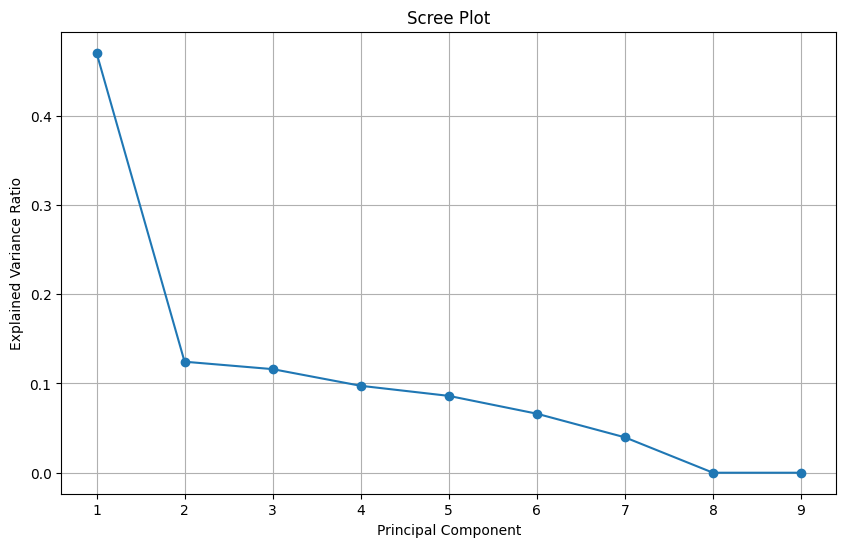

In [26]:

# Step 1: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Data_pca_numerical)

# Step 2: Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Step 3: Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Step 4: Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

In [27]:
principal_df = pd.DataFrame(data=pca_columns)



In [28]:
# Concatenate the principal components with other columns if needed
pca_df = pd.concat([num_df.reset_index(drop=True), principal_df], axis=1)

# Display the resulting DataFrame with 2 principal components
print(pca_df.head())

   id  overEstimationBurn  refundDecimal        refund  amountDecimal  \
0   0        6.436331e-05   1.301048e-03  1.301048e-03       0.331793   
1   0        6.881224e-12   2.643170e-11  2.643170e-11       0.117103   
2   7        9.994282e-03   2.897125e-02  2.897125e-02       0.111234   
3   6        2.399934e-03   1.988960e-02  1.988960e-02       0.007346   
4   5        2.829436e-04   1.125731e-02  1.125731e-02       0.000000   

   burnedDecimal  success  minerPenalty      minerTip  exitCode       gas  \
0   1.480909e-04        1           0.0  5.427090e-06         0  0.000869   
1   6.275459e-12        1           0.0  2.932049e-07         0  0.000037   
2   3.123789e-02        1           0.0  3.232164e-02         0  0.056080   
3   2.276021e-02        1           0.0  2.209272e-02         0  0.042012   
4   2.647547e-03        1           0.0  1.117123e-02         0  0.022369   

    baseFeeBurn  cluster       PC1       PC2  
0  1.414030e-04     1.00  0.628405  1.396625  
1  5

In [29]:

pca_cluster_df=pca_df[["id","success","exitCode","PC1","PC2"]]
pca_cluster_df.head()

,id,success,exitCode,PC1,PC2
0,0,1,0,0.628405,1.396625
1,0,1,0,-0.502629,0.530721
2,7,1,0,2.506598,0.555901
3,6,1,0,1.069515,-0.061469
4,5,1,0,-0.321680,-0.049387


In [33]:
categorical_indices_pca = [pca_cluster_df.columns.get_loc(col) for col in ['id', 'success', 'exitCode']]
categorical_indices_pca

[0, 1, 2]

In [34]:
def cluster(X,categorical_indices):
    costs = []
    n_clusters = []
    clusters_assigned = []
    silhouette_scores = []

    for i in range(2, 10):
        try:
            kproto = KPrototypes(n_clusters=i, init='Huang', random_state=42,n_jobs=-2,max_iter=5,n_init=10,verbose=2) 
            clusters = kproto.fit_predict(X, categorical=categorical_indices)
            costs.append(kproto.cost_)
            n_clusters.append(i)
            clusters_assigned.append(clusters)
            silhouette_avg = silhouette_score(X, clusters)
            silhouette_scores.append(silhouette_avg)
        except:
            print(f"Can't cluster with {i} clusters")

    return costs, n_clusters, clusters_assigned, silhouette_scores

costs_pca, n_clusters_pca, clusters_assigned_pca, silhouette_scores_pca = cluster(num_df,categorical_indices_pca)


Best run was number 1
Best run was number 3
Best run was number 4
Best run was number 6
Can't cluster with 6 clusters
Can't cluster with 7 clusters
Can't cluster with 8 clusters
Can't cluster with 9 clusters


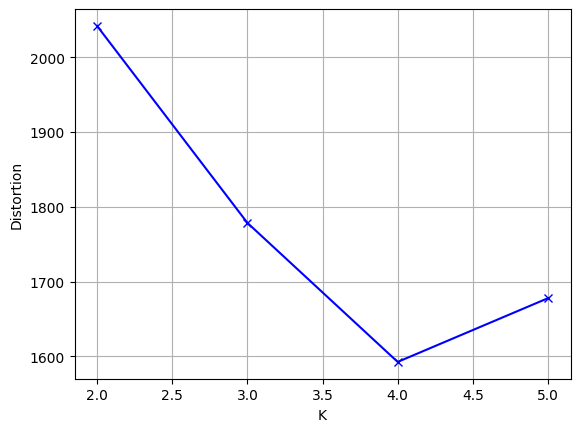

In [36]:

plt.plot(n_clusters_pca, costs_pca, 'bx-')
plt.ylabel('Distortion')
plt.xlabel('K');
plt.grid()

In [38]:
kproto = KPrototypes(n_clusters=5, init='Cao', n_init=2, verbose=2, random_state=42)

# Fit the model
clusters = kproto.fit_predict(pca_cluster_df.values, categorical=categorical_indices)

# Assign cluster labels to the DataFrame
pca_cluster_df['cluster'] = clusters

# Create a mapping dictionary for cluster labels
cluster_mapping = {0: 0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1}

# Map cluster labels to specified values
pca_cluster_df['cluster'] = pca_cluster_df['cluster'].map(cluster_mapping)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1544, ncost: 21659.877221763032
Run: 1, iteration: 2/100, moves: 999, ncost: 20773.59963351702
Run: 1, iteration: 3/100, moves: 837, ncost: 20338.066993651133
Run: 1, iteration: 4/100, moves: 703, ncost: 19972.878422787566
Run: 1, iteration: 5/100, moves: 591, ncost: 19563.348240948628
Run: 1, iteration: 6/100, moves: 520, ncost: 18729.085464295007
Run: 1, iteration: 7/100, moves: 494, ncost: 17901.85639461363
Run: 1, iteration: 8/100, moves: 410, ncost: 17233.918565762124
Run: 1, iteration: 9/100, moves: 379, ncost: 16708.945981470686
Run: 1, iteration: 10/100, moves: 310, ncost: 15359.131945165778
Run: 1, iteration: 11/100, moves: 186, ncost: 14695.246794001834
Run: 1, iteration: 12/100

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5856\711171379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_cluster_df['cluster'] = clusters
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5856\711171379.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_cluster_df['cluster'] = pca_cluster_df['cluster'].map(cluster_mapping)


In [39]:
pca_cluster_df.head()

,id,success,exitCode,PC1,PC2,cluster
0,0,1,0,0.628405,1.396625,0.25
1,0,1,0,-0.502629,0.530721,0.25
2,7,1,0,2.506598,0.555901,1.00
3,6,1,0,1.069515,-0.061469,1.00
4,5,1,0,-0.321680,-0.049387,0.25


In [40]:
result_vertical_pca = pd.concat([sender_df, pca_cluster_df], axis=1)

In [41]:

grouped_df_pca = result_vertical_pca.groupby('account').agg({
    'cluster': 'mean'})
print(grouped_df_pca)

            cluster
account            
f01096727  0.260369
f01136409  0.266917
f0115238   0.252885
f0116445   0.980535
f0117318   0.257772
f01399784  0.291892
f01437863  0.250000
f01501611  0.309064
f015747    0.250000
f01690871  0.250000
f01812283  0.250000
f02072747  0.260791
f02184150  0.343434
f022853    0.603922
f023858    0.338134
f023869    0.417864
f02387     0.379630
f02388     0.256356
f023928    0.371348
f023983    0.250000
f024146    0.282847
f024148    0.328431
f024511    0.492553
f029416    0.331606
f030649    0.250000
f034777    0.254237
f0471691   0.545409
f054526    0.409751
f0728347   0.250000
f0835643   0.280236


In [42]:
sorted_df_pca = grouped_df_pca.sort_values(by='cluster', ascending=True)
print(sorted_df_pca)

            cluster
account            
f030649    0.250000
f01437863  0.250000
f023983    0.250000
f015747    0.250000
f01690871  0.250000
f01812283  0.250000
f0728347   0.250000
f0115238   0.252885
f034777    0.254237
f02388     0.256356
f0117318   0.257772
f01096727  0.260369
f02072747  0.260791
f01136409  0.266917
f0835643   0.280236
f024146    0.282847
f01399784  0.291892
f01501611  0.309064
f024148    0.328431
f029416    0.331606
f023858    0.338134
f02184150  0.343434
f023928    0.371348
f02387     0.379630
f054526    0.409751
f023869    0.417864
f024511    0.492553
f0471691   0.545409
f022853    0.603922
f0116445   0.980535


In [60]:
sorted_df_pca.to_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filrepsubset_pca_expanded.csv")


Technique 3: Only MCA

In [44]:
num_df.head()

,id,overEstimationBurn,refundDecimal,refund,amountDecimal,burnedDecimal,success,minerPenalty,minerTip,exitCode,gas,baseFeeBurn,cluster
0,0,6.436331e-05,1.301048e-03,1.301048e-03,0.331793,1.480909e-04,1,0.0,5.427090e-06,0,0.000869,1.414030e-04,1.00
1,0,6.881224e-12,2.643170e-11,2.643170e-11,0.117103,6.275459e-12,1,0.0,2.932049e-07,0,0.000037,5.202649e-12,1.00
2,7,9.994282e-03,2.897125e-02,2.897125e-02,0.111234,3.123789e-02,1,0.0,3.232164e-02,0,0.056080,3.050795e-02,1.00
3,6,2.399934e-03,1.988960e-02,1.988960e-02,0.007346,2.276021e-02,1,0.0,2.209272e-02,0,0.042012,2.315616e-02,0.75
4,5,2.829436e-04,1.125731e-02,1.125731e-02,0.000000,2.647547e-03,1,0.0,1.117123e-02,0,0.022369,2.692888e-03,0.00


In [45]:
mca_categorical_columns=num_df[["id","success","exitCode"]]

In [46]:
mca_categorical_columns.head(5)

,id,success,exitCode
0,0,1,0
1,0,1,0
2,7,1,0
3,6,1,0
4,5,1,0


In [47]:
mca=prince.MCA(
    n_components=2,
    n_iter=4,
    copy=True,
    check_input=True,
    engine='sklearn',    
    random_state=42
)

In [48]:
mca=mca.fit(mca_categorical_columns)

In [49]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.675,12.65%,12.65%
1,0.430,8.06%,20.71%


In [50]:
mca.row_coordinates(mca_categorical_columns).head()

,0,1
0,0.079992,-0.313428
1,0.079992,-0.313428
2,0.005576,-0.116263
3,-0.129487,0.085849
4,-0.058104,-0.018777


In [51]:
mca.column_contributions_.head(100).style.format('{:.0%}')

,0,1
id_0,0%,0%
id_3,0%,0%
id_4,0%,0%
id_5,0%,0%
id_6,0%,0%
id_7,0%,0%
id_8,0%,0%
id_9,2%,46%
id_11,0%,0%
id_16,0%,0%


In [52]:
mca_coordinates = mca.row_coordinates(mca_categorical_columns)
mca_coordinates.columns = ['mca_1', 'mca_2']  # Rename columns
mca_df = pd.concat([num_df.reset_index(drop=True), mca_coordinates], axis=1)
mca_cluster_df = mca_df[['refund', 'refundDecimal', 'amountDecimal', 'burnedDecimal', 'overEstimationBurn', 'baseFeeBurn', 'minerPenalty', 'minerTip', 'gas', 'mca_1', 'mca_2']]
mca_cluster_df.head()

# Display the resulting DataFrame with 2 principal components


,refund,refundDecimal,amountDecimal,burnedDecimal,overEstimationBurn,baseFeeBurn,minerPenalty,minerTip,gas,mca_1,mca_2
0,1.301048e-03,1.301048e-03,0.331793,1.480909e-04,6.436331e-05,1.414030e-04,0.0,5.427090e-06,0.000869,0.079992,-0.313428
1,2.643170e-11,2.643170e-11,0.117103,6.275459e-12,6.881224e-12,5.202649e-12,0.0,2.932049e-07,0.000037,0.079992,-0.313428
2,2.897125e-02,2.897125e-02,0.111234,3.123789e-02,9.994282e-03,3.050795e-02,0.0,3.232164e-02,0.056080,0.005576,-0.116263
3,1.988960e-02,1.988960e-02,0.007346,2.276021e-02,2.399934e-03,2.315616e-02,0.0,2.209272e-02,0.042012,-0.129487,0.085849
4,1.125731e-02,1.125731e-02,0.000000,2.647547e-03,2.829436e-04,2.692888e-03,0.0,1.117123e-02,0.022369,-0.058104,-0.018777


In [53]:
hopkins(mca_cluster_df)

0.999534900834297

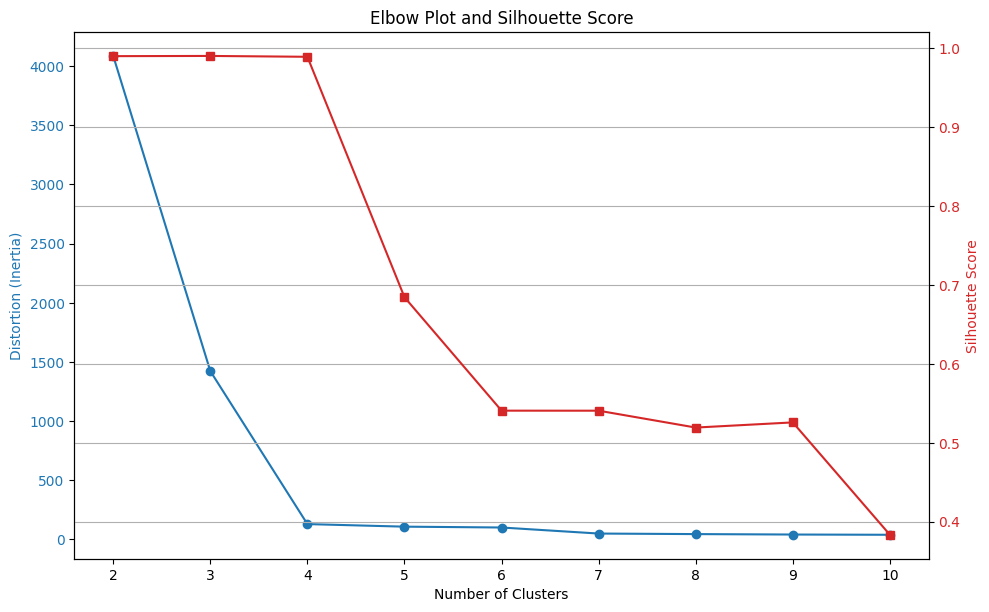

In [54]:


def plot_elbow_silhouette(X, max_clusters):
    distortions = []
    silhouette_scores = []
    
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        cluster_labels = kmeans.fit_predict(X)
        
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        
        distortions.append(kmeans.inertia_)

    # Plotting elbow plot
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Distortion (Inertia)', color=color)
    ax1.plot(range(2, max_clusters + 1), distortions, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx() 
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color) 
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout() 
    plt.title('Elbow Plot and Silhouette Score')
    plt.grid(True)
    plt.show()

# Example usage
# Assuming mca_cluster_df is your dataset and the maximum number of clusters to consider is 10
X = mca_cluster_df.values
max_clusters = 10
plot_elbow_silhouette(X, max_clusters)


In [55]:

def map_clusters(cluster_labels, cluster_mapping):
    # Map cluster labels to the specified values
    mapped_labels = [cluster_mapping[label] for label in cluster_labels]
    return mapped_labels

def kmeans_clustering(df, num_clusters, cluster_mapping):

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(df)
    
    # Map cluster labels to the specified values
    mapped_labels = map_clusters(cluster_labels, cluster_mapping)
    
    # Add cluster numbers to the original DataFrame
    df_with_clusters = df.copy()
    df_with_clusters['cluster'] = mapped_labels
    
    return df_with_clusters

# Example usage
# Defining the cluster mapping dictionary
cluster_mapping = {0: 0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1}


num_clusters = 5
mca_cluster_df_with_clusters = kmeans_clustering(mca_cluster_df, num_clusters, cluster_mapping)

# Display the DataFrame with cluster numbers
print(mca_cluster_df_with_clusters.head())


         refund  refundDecimal  amountDecimal  burnedDecimal  \
0  1.301048e-03   1.301048e-03       0.331793   1.480909e-04   
1  2.643170e-11   2.643170e-11       0.117103   6.275459e-12   
2  2.897125e-02   2.897125e-02       0.111234   3.123789e-02   
3  1.988960e-02   1.988960e-02       0.007346   2.276021e-02   
4  1.125731e-02   1.125731e-02       0.000000   2.647547e-03   

   overEstimationBurn   baseFeeBurn  minerPenalty      minerTip       gas  \
0        6.436331e-05  1.414030e-04           0.0  5.427090e-06  0.000869   
1        6.881224e-12  5.202649e-12           0.0  2.932049e-07  0.000037   
2        9.994282e-03  3.050795e-02           0.0  3.232164e-02  0.056080   
3        2.399934e-03  2.315616e-02           0.0  2.209272e-02  0.042012   
4        2.829436e-04  2.692888e-03           0.0  1.117123e-02  0.022369   

      mca_1     mca_2  cluster  
0  0.079992 -0.313428      0.0  
1  0.079992 -0.313428      0.0  
2  0.005576 -0.116263      0.0  
3 -0.129487  0.08584

In [56]:

result_vertical_mca = pd.concat([sender_df, mca_cluster_df_with_clusters], axis=1)

In [57]:

grouped_df_mca = result_vertical_mca.groupby('account').agg({
    'cluster': 'mean'})
print(grouped_df_mca)

            cluster
account            
f01096727  0.000000
f01136409  0.005639
f0115238   0.002885
f0116445   0.003650
f0117318   0.000000
f01399784  0.000000
f01437863  0.000000
f01501611  0.003715
f015747    0.000000
f01690871  0.000000
f01812283  0.000000
f02072747  0.005396
f02184150  0.001263
f022853    0.000000
f023858    0.001728
f023869    0.000000
f02387     0.001481
f02388     0.000000
f023928    0.002809
f023983    0.000000
f024146    0.001825
f024148    0.001838
f024511    0.000000
f029416    0.001295
f030649    0.000000
f034777    0.000000
f0471691   0.000499
f054526    0.001037
f0728347   0.116162
f0835643   0.010693


In [58]:
sorted_df_mca = grouped_df_mca.sort_values(by='cluster', ascending=True)
print(sorted_df_mca)

            cluster
account            
f01096727  0.000000
f023869    0.000000
f024511    0.000000
f022853    0.000000
f01812283  0.000000
f02388     0.000000
f015747    0.000000
f01690871  0.000000
f01437863  0.000000
f01399784  0.000000
f0117318   0.000000
f034777    0.000000
f030649    0.000000
f023983    0.000000
f0471691   0.000499
f054526    0.001037
f02184150  0.001263
f029416    0.001295
f02387     0.001481
f023858    0.001728
f024146    0.001825
f024148    0.001838
f023928    0.002809
f0115238   0.002885
f0116445   0.003650
f01501611  0.003715
f02072747  0.005396
f01136409  0.005639
f0835643   0.010693
f0728347   0.116162


In [61]:
sorted_df_mca.to_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filrepsubset_mca.csv")

Technique 4: MCA+PCA

In [62]:
mca=mca_cluster_df_with_clusters[['mca_1', 'mca_2']]
pca=pca_cluster_df[['PC1', 'PC2']]
mca_pca_df = pd.concat([mca,pca], axis=1)
mca_pca_df.head()

,mca_1,mca_2,PC1,PC2
0,0.079992,-0.313428,0.628405,1.396625
1,0.079992,-0.313428,-0.502629,0.530721
2,0.005576,-0.116263,2.506598,0.555901
3,-0.129487,0.085849,1.069515,-0.061469
4,-0.058104,-0.018777,-0.321680,-0.049387


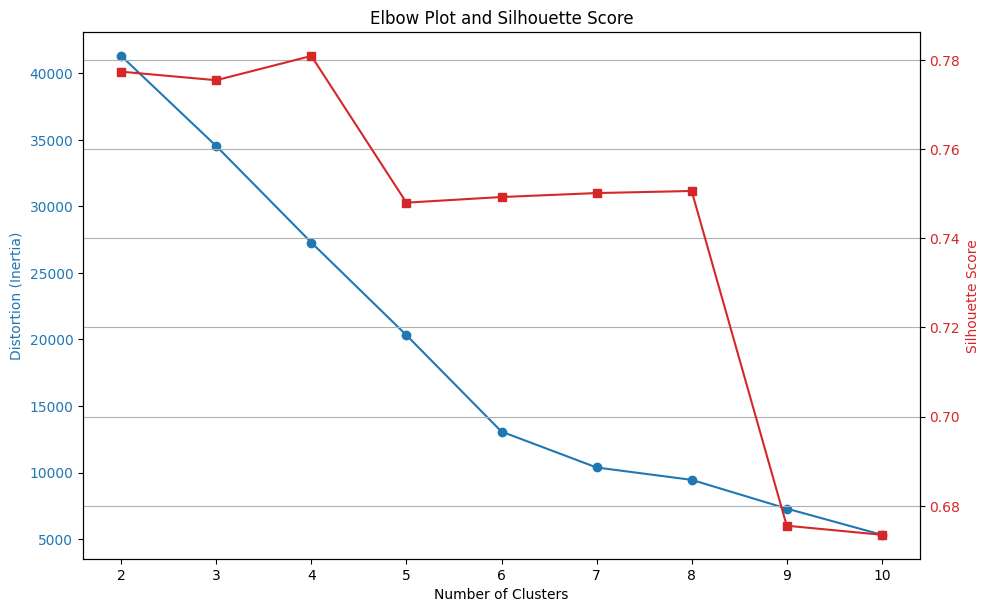

In [63]:

max_clusters = 10
plot_elbow_silhouette(mca_pca_df, max_clusters)

In [64]:
cluster_mapping = {0: 0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1}


num_clusters = 5
mca_pca_cluster = kmeans_clustering(mca_pca_df,num_clusters, cluster_mapping)

# Display the DataFrame with cluster numbers
print(mca_pca_cluster.head())


      mca_1     mca_2       PC1       PC2  cluster
0  0.079992 -0.313428  0.628405  1.396625     0.00
1  0.079992 -0.313428 -0.502629  0.530721     0.00
2  0.005576 -0.116263  2.506598  0.555901     0.25
3 -0.129487  0.085849  1.069515 -0.061469     0.25
4 -0.058104 -0.018777 -0.321680 -0.049387     0.00


In [65]:
result_vertical_mca_pca = pd.concat([sender_df, mca_pca_cluster[['cluster']]], axis=1)
result_vertical_mca_pca.head()

,account,cluster
0,f01690871,0.00
1,f01690871,0.00
2,f02184150,0.25
3,f02184150,0.25
4,f02184150,0.00


In [66]:
grouped_df_mca_pca = result_vertical_mca_pca.groupby('account').agg({
    'cluster': 'mean'})
print(grouped_df_mca_pca)

            cluster
account            
f01096727  0.003456
f01136409  0.004699
f0115238   0.000962
f0116445   0.251217
f0117318   0.000648
f01399784  0.016216
f01437863  0.000000
f01501611  0.018202
f015747    0.000000
f01690871  0.000000
f01812283  0.000000
f02072747  0.001799
f02184150  0.049242
f022853    0.124510
f023858    0.019585
f023869    0.054415
f02387     0.041852
f02388     0.002119
f023928    0.034831
f023983    0.000000
f024146    0.008516
f024148    0.021446
f024511    0.078723
f029416    0.039184
f030649    0.000000
f034777    0.001412
f0471691   0.132236
f054526    0.047718
f0728347   0.000000
f0835643   0.015487


In [67]:
sorted_df_mca_pca = grouped_df_mca_pca.sort_values(by='cluster', ascending=True)
print(sorted_df_mca_pca)

            cluster
account            
f030649    0.000000
f01437863  0.000000
f015747    0.000000
f01690871  0.000000
f01812283  0.000000
f023983    0.000000
f0728347   0.000000
f0117318   0.000648
f0115238   0.000962
f034777    0.001412
f02072747  0.001799
f02388     0.002119
f01096727  0.003456
f01136409  0.004699
f024146    0.008516
f0835643   0.015487
f01399784  0.016216
f01501611  0.018202
f023858    0.019585
f024148    0.021446
f023928    0.034831
f029416    0.039184
f02387     0.041852
f054526    0.047718
f02184150  0.049242
f023869    0.054415
f024511    0.078723
f022853    0.124510
f0471691   0.132236
f0116445   0.251217


In [68]:
sorted_df_mca_pca.to_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filrepsubset_mca_pca.csv")

Technique 5: FAMD 

Factor analysis of mixed data (FAMD) is a factorial method used to analyze data tables that contain both quantitative and qualitative variables12. It is a principal component method that makes it possible to analyze the similarity between individuals by taking into account mixed types of variables2. The method was initially developed by Hill and Smith in 1972, and a few variants of this method have been developed since then

In [69]:
num_df.head(10)

,id,overEstimationBurn,refundDecimal,refund,amountDecimal,burnedDecimal,success,minerPenalty,minerTip,exitCode,gas,baseFeeBurn,cluster
0,0,6.436331e-05,1.301048e-03,1.301048e-03,0.331793,1.480909e-04,1,0.0,5.427090e-06,0,0.000869,1.414030e-04,1.00
1,0,6.881224e-12,2.643170e-11,2.643170e-11,0.117103,6.275459e-12,1,0.0,2.932049e-07,0,0.000037,5.202649e-12,1.00
2,7,9.994282e-03,2.897125e-02,2.897125e-02,0.111234,3.123789e-02,1,0.0,3.232164e-02,0,0.056080,3.050795e-02,1.00
3,6,2.399934e-03,1.988960e-02,1.988960e-02,0.007346,2.276021e-02,1,0.0,2.209272e-02,0,0.042012,2.315616e-02,0.75
4,5,2.829436e-04,1.125731e-02,1.125731e-02,0.000000,2.647547e-03,1,0.0,1.117123e-02,0,0.022369,2.692888e-03,0.00
5,5,5.005863e-04,4.990097e-03,4.990097e-03,0.000000,4.692605e-03,1,0.0,4.904533e-03,0,0.010235,4.773143e-03,0.00
6,5,6.767791e-04,4.880740e-03,4.880740e-03,0.000000,6.344274e-03,1,0.0,5.411078e-03,0,0.010235,6.453160e-03,0.00
7,5,1.739162e-03,4.227370e-02,4.227370e-02,0.000000,1.625486e-02,1,0.0,4.320453e-02,0,0.085390,1.653286e-02,0.00
8,7,3.808423e-04,1.435944e-02,1.435944e-02,0.084932,8.799134e-03,1,0.0,1.498074e-02,0,0.030494,9.056160e-03,1.00
9,11,4.667882e-04,4.245053e-03,4.245053e-03,0.000000,4.401456e-03,1,0.0,4.523328e-03,0,0.008735,4.477518e-03,0.75


In [70]:
famd_df=num_df

In [122]:
famd=prince.FAMD(
    n_components=19,
    n_iter=4,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
famd.fit(famd_df)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.2216290575826192, -0.012734979195199858, -0.02205763099941876, -0.08350884318078804, -0.025469958390399717, -0.0336935879020803, -1.1653027877296511, -0.15175479137249206, -0.1347743516083212, -0.05402994088317253, -0.06857996178158036, -0.204157247339541, -0.21233453614144862, -0.050939916780799434, -0.08730661870558348]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


FAMD(n_components=19, n_iter=4, random_state=42)

In [129]:
famd_eigen=famd.eigenvalues_summary['eigenvalue']

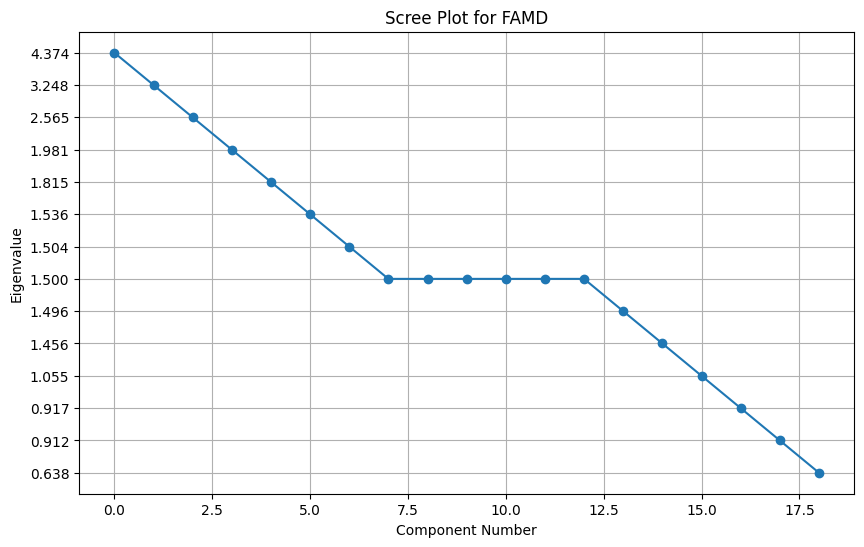

In [133]:
famd_df_sorted = famd_eigen.sort_index()

# Plot the eigenvalues as a line chart
plt.figure(figsize=(10, 6))
plt.plot(famd_eigen.index, famd_eigen, marker='o', linestyle='-')
plt.gca().invert_yaxis()

# Title and labels
plt.title('Scree Plot for FAMD')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')

# Show the plot
plt.grid(True)
plt.show()

In [134]:
famd=prince.FAMD(
    n_components=8,
    n_iter=6,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
famd.fit(famd_df)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.2216290575826192, -0.012734979195199858, -0.02205763099941876, -0.08350884318078804, -0.025469958390399717, -0.0336935879020803, -1.1653027877296511, -0.15175479137249206, -0.1347743516083212, -0.05402994088317253, -0.06857996178158036, -0.204157247339541, -0.21233453614144862, -0.050939916780799434, -0.08730661870558348]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


FAMD(n_components=8, n_iter=6, random_state=42)

In [136]:
famd.row_coordinates(famd_df).head(100)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.2216290575826192, -0.012734979195199858, -0.02205763099941876, -0.08350884318078804, -0.025469958390399717, -0.0336935879020803, -1.1653027877296511, -0.15175479137249206, -0.1347743516083212, -0.05402994088317253, -0.06857996178158036, -0.204157247339541, -0.21233453614144862, -0.050939916780799434, -0.08730661870558348]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


component,0,1,2,3,4,5,6,7
0,2.012068,-1.342489,16.965993,-4.675648,14.708761,-46.384250,-0.428754,5.917213
1,0.590696,-0.912794,13.205679,-3.160338,11.255863,-45.229378,-0.425118,5.913789
2,4.254714,-1.407282,9.927931,-2.303826,5.080793,0.033273,0.096681,-0.054777
3,1.364996,-0.784052,4.732004,1.448239,-4.682097,-0.967258,-1.279995,-5.376652
4,-0.385969,-0.016426,-0.465423,-0.106067,0.250830,-0.016991,-0.057634,-0.054604
...,...,...,...,...,...,...,...,...
95,-0.827726,0.076871,-0.390205,-0.094718,0.299926,0.000967,-0.036182,-0.061192
96,-0.763527,0.064708,-0.398248,-0.094138,0.293388,0.001417,-0.034794,-0.062199
97,-0.791146,0.069927,-0.394802,-0.094390,0.296186,0.001231,-0.035376,-0.061776
98,-0.846941,0.080459,-0.387853,-0.094901,0.301826,0.000864,-0.036537,-0.060933


In [137]:
famd_df_c=famd.row_coordinates(famd_df)

famd_df_c.head()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.2216290575826192, -0.012734979195199858, -0.02205763099941876, -0.08350884318078804, -0.025469958390399717, -0.0336935879020803, -1.1653027877296511, -0.15175479137249206, -0.1347743516083212, -0.05402994088317253, -0.06857996178158036, -0.204157247339541, -0.21233453614144862, -0.050939916780799434, -0.08730661870558348]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


component,0,1,2,3,4,5,6,7
0,2.012068,-1.342489,16.965993,-4.675648,14.708761,-46.384250,-0.428754,5.917213
1,0.590696,-0.912794,13.205679,-3.160338,11.255863,-45.229378,-0.425118,5.913789
2,4.254714,-1.407282,9.927931,-2.303826,5.080793,0.033273,0.096681,-0.054777
3,1.364996,-0.784052,4.732004,1.448239,-4.682097,-0.967258,-1.279995,-5.376652
4,-0.385969,-0.016426,-0.465423,-0.106067,0.250830,-0.016991,-0.057634,-0.054604


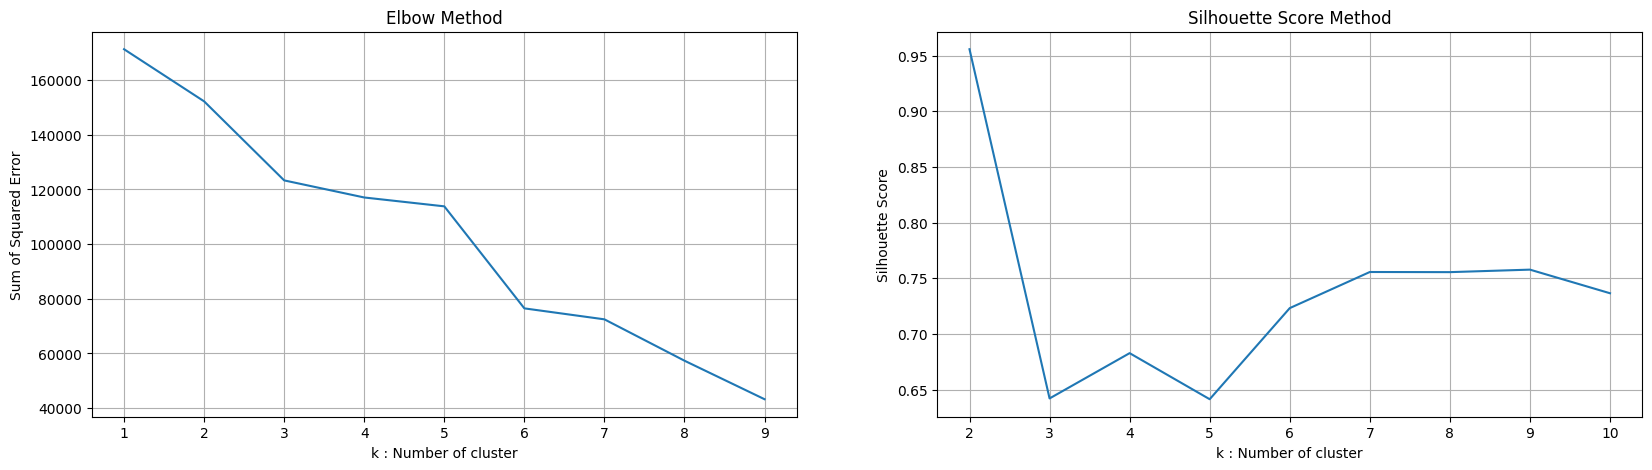

In [139]:
sse = {};sil = [];kmax = 10
fig = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

# Elbow Method :
plt.subplot(1,2,1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(famd_df_c)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

# Silhouette Score Method
plt.subplot(1,2,2)
for k in range(2, kmax + 1):
    kmeans = KMeans(n_clusters = k).fit(famd_df_c)
    labels = kmeans.labels_
    sil.append(silhouette_score(famd_df_c, labels, metric = 'euclidean'))
sns.lineplot(x = range(2,kmax + 1), y = sil);
plt.title('Silhouette Score Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Silhouette Score")
plt.grid()

plt.show()

In [75]:
cluster_mapping = {0: 0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1}


num_clusters = 5
famd_cluster = kmeans_clustering(famd_df_c,num_clusters, cluster_mapping)

# Display the DataFrame with cluster numbers
print(famd_cluster.head())


component         0         1          2         3          4  cluster
0          1.992499 -1.608115  17.391131 -3.184447  14.811548     0.75
1          0.570667 -1.181798  13.618763 -1.704650  11.288258     0.75
2          4.257186 -1.376013   9.918101 -2.316960   5.218085     0.75
3          1.371949 -0.700360   4.650049  1.256692  -4.373065     0.50
4         -0.385809 -0.016509  -0.463958 -0.102746   0.261419     0.00


In [76]:
result_vertical_famd= pd.concat([sender_df, famd_cluster[['cluster']]], axis=1)
result_vertical_famd.head()

,account,cluster
0,f01690871,0.75
1,f01690871,0.75
2,f02184150,0.75
3,f02184150,0.50
4,f02184150,0.00


In [77]:
grouped_df_famd = result_vertical_famd.groupby('account').agg({
    'cluster': 'mean'})
print(grouped_df_famd)

            cluster
account            
f01096727  0.013825
f01136409  0.072368
f0115238   0.009615
f0116445   0.810219
f0117318   0.003886
f01399784  0.218919
f01437863  0.009259
f01501611  0.031575
f015747    0.041436
f01690871  0.750000
f01812283  0.069444
f02072747  0.066547
f02184150  0.123737
f022853    0.480392
f023858    0.038594
f023869    0.095483
f02387     0.094074
f02388     0.044492
f023928    0.036517
f023983    0.006250
f024146    0.013990
f024148    0.023897
f024511    0.336170
f029416    0.176166
f030649    0.015432
f034777    0.073446
f0471691   0.396208
f054526    0.177386
f0728347   0.108586
f0835643   0.157080


In [78]:
sorted_famd= grouped_df_famd.sort_values(by='cluster', ascending=True)
print(sorted_famd)

            cluster
account            
f0117318   0.003886
f023983    0.006250
f01437863  0.009259
f0115238   0.009615
f01096727  0.013825
f024146    0.013990
f030649    0.015432
f024148    0.023897
f01501611  0.031575
f023928    0.036517
f023858    0.038594
f015747    0.041436
f02388     0.044492
f02072747  0.066547
f01812283  0.069444
f01136409  0.072368
f034777    0.073446
f02387     0.094074
f023869    0.095483
f0728347   0.108586
f02184150  0.123737
f0835643   0.157080
f029416    0.176166
f054526    0.177386
f01399784  0.218919
f024511    0.336170
f0471691   0.396208
f022853    0.480392
f01690871  0.750000
f0116445   0.810219


In [79]:
sorted_famd.to_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filrepsubset_famd.csv")

In [86]:
filtered_df = num_df[num_df['success'] == False]

# Print the filtered DataFrame
filtered_df.head(50)

,id,overEstimationBurn,refundDecimal,refund,amountDecimal,burnedDecimal,success,minerPenalty,minerTip,exitCode,gas,baseFeeBurn,cluster
44,7,3.499529e-01,4.287446e-02,4.287446e-02,0.252203,6.705764e-02,0,0.000000,0.057051,6,0.004702,3.061466e-03,1.00
824,5,1.750317e-01,6.992326e-03,6.992326e-03,0.000000,3.401927e-02,0,0.000000,0.033571,16,0.003334,2.029040e-03,0.00
826,5,8.388306e-09,4.948415e-08,4.948415e-08,0.000000,1.604397e-09,0,0.000000,0.000021,16,0.000505,7.030958e-11,0.00
828,5,2.527111e-08,2.975474e-09,2.975474e-09,0.000000,4.889842e-09,0,0.000000,0.000034,16,0.001942,2.702687e-10,0.00
1446,5,7.383813e-08,0.000000e+00,0.000000e+00,0.000000,1.452532e-08,0,0.000000,0.000005,16,0.000176,1.036577e-09,0.00
1582,5,1.679567e-06,4.006033e-03,4.006033e-03,0.000000,3.167445e-07,0,0.000000,0.000130,16,0.000955,9.410069e-09,0.00
1729,5,8.278813e-08,6.898014e-03,6.898014e-03,0.000000,1.606208e-08,0,0.000000,0.057650,16,0.006120,9.299673e-10,0.00
1732,5,8.451162e-09,4.073273e-09,4.073273e-09,0.000000,1.615890e-09,0,0.000000,0.000019,16,0.000505,7.028735e-11,0.00
1733,5,8.041836e-09,9.703935e-10,9.703935e-10,0.000000,1.540907e-09,0,0.000000,0.000011,16,0.000505,7.028735e-11,0.00
2171,5,3.454671e-01,1.721580e-03,1.721580e-03,0.000000,6.703899e-02,0,0.000000,0.040152,16,0.004017,3.894616e-03,0.00


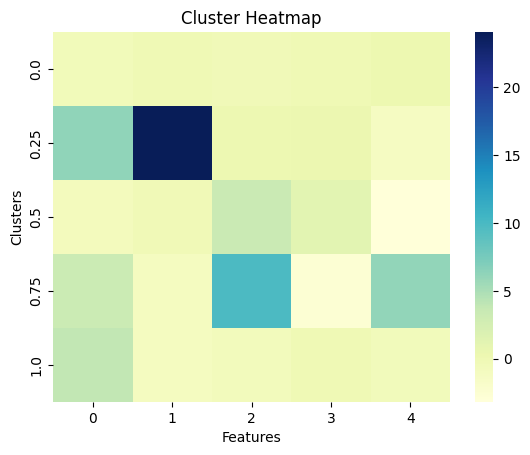

In [81]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your clustered data matrix and 'cluster_labels' is the cluster labels assigned to each data point
# Aggregate data based on cluster labels
cluster_means = famd_cluster.groupby('cluster').mean()  # You can use other aggregation functions like median, sum, etc.

# Create heatmap
sns.heatmap(cluster_means, cmap="YlGnBu")
plt.title('Cluster Heatmap')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()


In [105]:

famd_df2= num_df
famd=prince.FAMD(
    n_components=8,
    n_iter=4,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
famd.fit(famd_df)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.2216290575826192, -0.012734979195199858, -0.02205763099941876, -0.08350884318078804, -0.025469958390399717, -0.0336935879020803, -1.1653027877296511, -0.15175479137249206, -0.1347743516083212, -0.05402994088317253, -0.06857996178158036, -0.204157247339541, -0.21233453614144862, -0.050939916780799434, -0.08730661870558348]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


FAMD(n_components=8, n_iter=4, random_state=42)

In [106]:
famd_df_c2=famd.row_coordinates(famd_df2)

famd_df_c2.head()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\prince\pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.2216290575826192, -0.012734979195199858, -0.02205763099941876, -0.08350884318078804, -0.025469958390399717, -0.0336935879020803, -1.1653027877296511, -0.15175479137249206, -0.1347743516083212, -0.05402994088317253, -0.06857996178158036, -0.204157247339541, -0.21233453614144862, -0.050939916780799434, -0.08730661870558348]'. Picking the first and converting the rest.
  X = self.scaler_.transform(X.to_numpy())


component,0,1,2,3,4,5,6,7
0,2.013011,-1.339903,16.946518,-4.546522,14.612851,-46.634653,-1.026765,6.007859
1,0.591554,-0.910472,13.188826,-3.055633,11.157166,-45.470489,-1.013891,6.002226
2,4.254933,-1.406221,9.922817,-2.268349,5.079252,0.064145,0.124366,-0.059152
3,1.364838,-0.784420,4.736294,1.415485,-4.687124,-0.921420,-1.300913,-5.418501
4,-0.386044,-0.016594,-0.464551,-0.107285,0.256830,-0.019699,-0.056825,-0.054485


In [107]:
cluster_mapping = {0: 0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1}


num_clusters = 5
famd_cluster2 = kmeans_clustering(famd_df_c2,num_clusters, cluster_mapping)

# Display the DataFrame with cluster numbers
print(famd_cluster2.head())

component         0         1          2         3          4          5  \
0          2.013011 -1.339903  16.946518 -4.546522  14.612851 -46.634653   
1          0.591554 -0.910472  13.188826 -3.055633  11.157166 -45.470489   
2          4.254933 -1.406221   9.922817 -2.268349   5.079252   0.064145   
3          1.364838 -0.784420   4.736294  1.415485  -4.687124  -0.921420   
4         -0.386044 -0.016594  -0.464551 -0.107285   0.256830  -0.019699   

component         6         7  cluster  
0         -1.026765  6.007859     0.75  
1         -1.013891  6.002226     0.75  
2          0.124366 -0.059152     0.75  
3         -1.300913 -5.418501     0.75  
4         -0.056825 -0.054485     0.00  


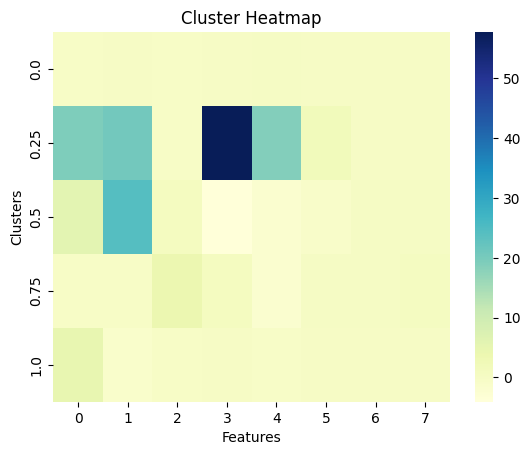

In [108]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'data' is your clustered data matrix and 'cluster_labels' is the cluster labels assigned to each data point
# Aggregate data based on cluster labels
cluster_means = famd_cluster2.groupby('cluster').mean()  # You can use other aggregation functions like median, sum, etc.

# Create heatmap
sns.heatmap(cluster_means, cmap="YlGnBu")
plt.title('Cluster Heatmap')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()


Analysis of Results

In [8]:
import pandas as pd
df=pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filrepsubset_pca_expanded.csv")
df1=pd.read_csv("C:\\Users\\Lenovo\\Desktop\\Reputation System\\subset_data\\expanded subset\\filrepsubset_famd.csv")

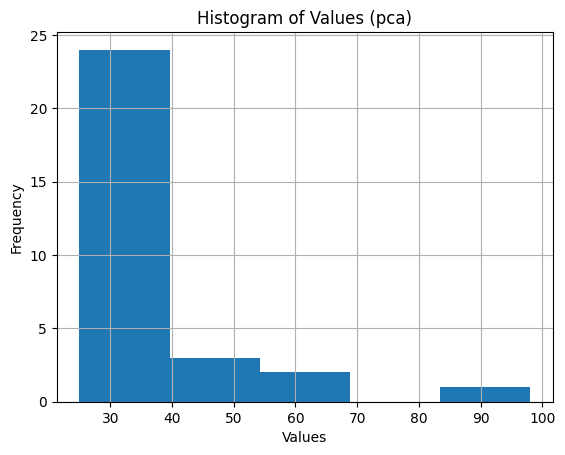

In [11]:
import matplotlib.pyplot as plt
plt.hist(df["cluster"]*100, bins=5)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values (pca)')
plt.grid()
plt.show()

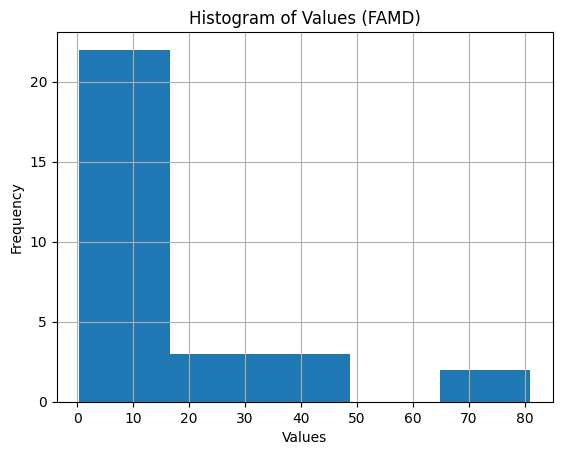

In [12]:
import matplotlib.pyplot as plt
plt.hist(df1["cluster"]*100, bins=5)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Values (FAMD)')
plt.grid()
plt.show()